In [116]:
#Importing Required Libraries

import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [117]:
#PART 1: DATA CLEANING/FEATURE ENGINEERING

#Reading files

articles_df = pd.read_csv('/Users/chidinmaumenwofor-nweze/Desktop/side projects/collab-filtering-tutorial/articles-sharing-reading-from-cit-deskdrop/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED'] #Only reading the content removed

interactions_df = pd.read_csv('/Users/chidinmaumenwofor-nweze/Desktop/side projects/collab-filtering-tutorial/articles-sharing-reading-from-cit-deskdrop/users_interactions.csv')

In [118]:
#Next it is a good idea to give each interaction a weighting. 
#I.e. a comment indicates greater interest than a like or simply viewing the article.
#I changed the weightings slightly from the tutorial based on my own heuristics to see what affect it would have :).

event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.5, #originally 3.0
   'COMMENT CREATED': 3.0, #originally 4.0  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

In [119]:
#Due to user cold-start, users with less than 5 interactions are ignored.

users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# users: 1895
# users with at least 5 interactions: 1140
# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


In [120]:
#To model the user interest in an article, the weighted sum of the event strengths of 
#all interactions performed on the article by a user is calculated and then a log transformation
#is applied to smooth the transformation

def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))


# of unique user/item interactions: 39106


In [121]:
#PART 2: CREATING THE EVALUATION FRAMEWORK

#Using the holdout approach to cross-validation I will holdout 30% of the dataset for testing
#(in contrast to the original 20% from the tutorial to prevent overfitting)

interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.30,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 27374
# interactions on Test set: 11732


In [122]:
#The following uses the Top-N accuracy metric Recall@N 
#which evaluates whether the interacted item is among the top N items (hit) 
#in the ranked list of 101 recommendations for a user.
#This will be used to evaluate the different models explored in the next parts

#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the article information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
        
    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df), topn=10000000000)
        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to not be relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
            #when mixed with a set of non-relevant items
            recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
            recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

            person_metrics = {'hits@5_count':hits_at_5_count, 
                'hits@10_count':hits_at_10_count, 
                'interacted_count': interacted_items_count_testset,
                'recall@5': recall_at_5,
                'recall@10': recall_at_10}
            return person_metrics
        
    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        #if idx % 100 == 0 and idx > 0:
        #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
            print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
    model_evaluator = ModelEvaluator() 


In [123]:
#PART 3: THE POPULARITY MODEL

#This is not a personalized recommender.
#It simply reccommends the most popular articles to the reader.

#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

#Not the eventStrength values are only slightly different from those in the tutorial
#due to my change in the weighting of each event

,contentId,eventStrength
0,-4029704725707465084,307.627726
1,-6783772548752091658,233.164560
2,-133139342397538859,227.911400
3,-8208801367848627943,196.788481
4,-6843047699859121724,193.635183
5,8224860111193157980,189.046345
6,-2358756719610361882,182.597360
7,2581138407738454418,180.062362
8,7507067965574797372,178.592583
9,1469580151036142903,170.514870


In [124]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)].sort_values('eventStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [125]:
#The next step is to evaluate the popularity model, using the evaluation class
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)

#The recall@5 is only 3% compared to the 24% in the tutorial 
#and the recall@10 is only 4% compared to 37% in the tutorial

Evaluating Popularity recommendation model...
0 users processed
1 users processed
2 users processed
3 users processed
4 users processed
5 users processed
6 users processed
7 users processed
8 users processed
9 users processed
10 users processed
11 users processed
12 users processed
13 users processed
14 users processed
15 users processed
16 users processed
17 users processed
18 users processed
19 users processed
20 users processed
21 users processed
22 users processed
23 users processed
24 users processed
25 users processed
26 users processed
27 users processed
28 users processed
29 users processed
30 users processed
31 users processed
32 users processed
33 users processed
34 users processed
35 users processed
36 users processed
37 users processed
38 users processed
39 users processed
40 users processed
41 users processed
42 users processed
43 users processed
44 users processed
45 users processed
46 users processed
47 users processed
48 users processed
49 users processed
50 users proce

421 users processed
422 users processed
423 users processed
424 users processed
425 users processed
426 users processed
427 users processed
428 users processed
429 users processed
430 users processed
431 users processed
432 users processed
433 users processed
434 users processed
435 users processed
436 users processed
437 users processed
438 users processed
439 users processed
440 users processed
441 users processed
442 users processed
443 users processed
444 users processed
445 users processed
446 users processed
447 users processed
448 users processed
449 users processed
450 users processed
451 users processed
452 users processed
453 users processed
454 users processed
455 users processed
456 users processed
457 users processed
458 users processed
459 users processed
460 users processed
461 users processed
462 users processed
463 users processed
464 users processed
465 users processed
466 users processed
467 users processed
468 users processed
469 users processed
470 users processed


831 users processed
832 users processed
833 users processed
834 users processed
835 users processed
836 users processed
837 users processed
838 users processed
839 users processed
840 users processed
841 users processed
842 users processed
843 users processed
844 users processed
845 users processed
846 users processed
847 users processed
848 users processed
849 users processed
850 users processed
851 users processed
852 users processed
853 users processed
854 users processed
855 users processed
856 users processed
857 users processed
858 users processed
859 users processed
860 users processed
861 users processed
862 users processed
863 users processed
864 users processed
865 users processed
866 users processed
867 users processed
868 users processed
869 users processed
870 users processed
871 users processed
872 users processed
873 users processed
874 users processed
875 users processed
876 users processed
877 users processed
878 users processed
879 users processed
880 users processed


In [126]:
#PART 4: Content-Based Filtering Model
#Recommends the user new articles based on how they felt about previous items.
#This helps avoid the cold-start problem.
#To judge the similarity of items TF-IDF and Cosine similarity is employed.


#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [127]:
#To model the user profile, all the item profiles the user has interacted with is averaged. 
#Of course, the average is weighted by the interaction strength.

def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

user_profiles = build_users_profiles()
len(user_profiles)


1140

In [128]:
#Dislaying an example profile
example_profile = user_profiles[-1479311724257856983]
print(example_profile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])
#due to my different weightings, different words are more relevant to this person
#than what was determined in the tutorial.
#In my model, words like apple, netflix, and search are more relevant to this person than 
#words like people. I'm interested to see what result this has in the end on accuracy.

(1, 5000)


,token,relevance
0,learning,0.288935
1,machine learning,0.240279
2,machine,0.233300
3,google,0.215550
4,ai,0.171651
5,data,0.159770
6,algorithms,0.119401
7,like,0.093238
8,language,0.088581
9,apple,0.081390


In [129]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)   

In [130]:
#Next is to evaluate the model
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)

Evaluating Content-Based Filtering model...
0 users processed
1 users processed
2 users processed
3 users processed
4 users processed
5 users processed
6 users processed
7 users processed
8 users processed
9 users processed
10 users processed
11 users processed
12 users processed
13 users processed
14 users processed
15 users processed
16 users processed
17 users processed
18 users processed
19 users processed
20 users processed
21 users processed
22 users processed
23 users processed
24 users processed
25 users processed
26 users processed
27 users processed
28 users processed
29 users processed
30 users processed
31 users processed
32 users processed
33 users processed
34 users processed
35 users processed
36 users processed
37 users processed
38 users processed
39 users processed
40 users processed
41 users processed
42 users processed
43 users processed
44 users processed
45 users processed
46 users processed
47 users processed
48 users processed
49 users processed
50 users process

428 users processed
429 users processed
430 users processed
431 users processed
432 users processed
433 users processed
434 users processed
435 users processed
436 users processed
437 users processed
438 users processed
439 users processed
440 users processed
441 users processed
442 users processed
443 users processed
444 users processed
445 users processed
446 users processed
447 users processed
448 users processed
449 users processed
450 users processed
451 users processed
452 users processed
453 users processed
454 users processed
455 users processed
456 users processed
457 users processed
458 users processed
459 users processed
460 users processed
461 users processed
462 users processed
463 users processed
464 users processed
465 users processed
466 users processed
467 users processed
468 users processed
469 users processed
470 users processed
471 users processed
472 users processed
473 users processed
474 users processed
475 users processed
476 users processed
477 users processed


842 users processed
843 users processed
844 users processed
845 users processed
846 users processed
847 users processed
848 users processed
849 users processed
850 users processed
851 users processed
852 users processed
853 users processed
854 users processed
855 users processed
856 users processed
857 users processed
858 users processed
859 users processed
860 users processed
861 users processed
862 users processed
863 users processed
864 users processed
865 users processed
866 users processed
867 users processed
868 users processed
869 users processed
870 users processed
871 users processed
872 users processed
873 users processed
874 users processed
875 users processed
876 users processed
877 users processed
878 users processed
879 users processed
880 users processed
881 users processed
882 users processed
883 users processed
884 users processed
885 users processed
886 users processed
887 users processed
888 users processed
889 users processed
890 users processed
891 users processed


In [131]:
#PART 5: Collaborative Filtering Model (Singular Value Decomposition (SVD))
#This model employs matrix factorization, 
#and then matrix multiplication to fill in the 'missing values' to make predictions. 
#This concept should become clearer below.

#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [133]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [134]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1140x2885 sparse matrix of type '<class 'numpy.float64'>'
	with 27374 stored elements in Compressed Sparse Row format>

In [135]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
print(U.shape)
print(Vt.shape)
sigma = np.diag(sigma)
print(sigma.shape)

(1140, 15)
(15, 2885)
(15, 15)


In [136]:
#Now the original matrix can be reconstructed by multiplying its factors. 
#The resulting matrix is not sparse any more. 
#It was generated predictions for items the user have not yet interacted with.
#This can then be leveraged to make recommendations.

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 7.58959659e-03,  2.43623386e-03, -9.05839128e-03, ...,
        -7.65117812e-03,  2.02527413e-02,  2.25554431e-03],
       [ 4.85828515e-03,  1.23432400e-03, -2.62297001e-06, ...,
         8.40984775e-03, -3.95337312e-03, -6.83542694e-04],
       [-1.14592944e-02,  1.17988435e-02, -3.31301920e-03, ...,
        -1.77288427e-02, -2.86260809e-02,  7.86464749e-03],
       ...,
       [-1.08037708e-02,  1.03473499e-02, -2.67945673e-03, ...,
        -4.52955257e-02, -2.67543499e-02,  1.11710731e-02],
       [-1.47491828e-02,  6.39253720e-03, -2.01957710e-03, ...,
        -1.29720059e-02, -7.51363202e-03,  1.26882234e-03],
       [-4.07349102e-02, -4.51841344e-04,  7.63693209e-02, ...,
        -1.56405183e-02,  5.49540008e-02,  7.18475072e-03]])

In [137]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [138]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

#The values below, are approximately twice the value of those in the original tutorial.

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.212566,0.212283,0.210597,0.215239,0.210810,0.211446,0.210839,0.215758,0.211445,0.215403,...,0.210524,0.208882,0.211301,0.212447,0.211511,0.211269,0.209958,0.210664,0.210256,0.207570
-9216926795620865886,0.212033,0.211909,0.213001,0.211776,0.211689,0.211877,0.211882,0.211640,0.211873,0.212316,...,0.211852,0.212477,0.211831,0.211859,0.212137,0.211830,0.211843,0.212851,0.212442,0.211734
-9194572880052200111,0.210845,0.211781,0.211439,0.211232,0.212529,0.211314,0.213966,0.210356,0.211516,0.209916,...,0.212077,0.210706,0.212914,0.214188,0.231386,0.212503,0.213769,0.211504,0.211572,0.219675
-9192549002213406534,0.214829,0.211645,0.207929,0.211423,0.213251,0.212122,0.212502,0.218675,0.213138,0.209097,...,0.212607,0.232641,0.212432,0.211684,0.216912,0.212542,0.212117,0.206551,0.211128,0.221245
-9190737901804729417,0.212928,0.211624,0.211552,0.212046,0.211850,0.211791,0.212124,0.211745,0.211090,0.212957,...,0.212321,0.212896,0.211772,0.211710,0.210322,0.211786,0.212108,0.211563,0.212236,0.211309
-9189659052158407108,0.214379,0.212993,0.212192,0.211507,0.212567,0.211974,0.212511,0.212180,0.213715,0.211678,...,0.214569,0.217531,0.211941,0.212188,0.223804,0.212545,0.212948,0.212908,0.213922,0.217292
-9176143510534135851,0.215303,0.212267,0.213749,0.212082,0.211994,0.211367,0.212944,0.214417,0.219776,0.217566,...,0.212078,0.223492,0.210582,0.211360,0.207327,0.211738,0.213201,0.216974,0.215217,0.218171
-9172673334835262304,0.212094,0.211924,0.212402,0.211706,0.211788,0.211886,0.211930,0.211970,0.210958,0.211833,...,0.212221,0.214087,0.211866,0.211703,0.211191,0.211767,0.211971,0.211943,0.212435,0.211830
-9171475473795142532,0.211976,0.211880,0.212057,0.211714,0.211790,0.211949,0.211962,0.211766,0.211619,0.212224,...,0.211767,0.211289,0.211889,0.211864,0.211117,0.211759,0.211643,0.211812,0.211971,0.212021


In [139]:
#Now building the recommender

class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [140]:
#Now evaluating the model

print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
0 users processed
1 users processed
2 users processed
3 users processed
4 users processed
5 users processed
6 users processed
7 users processed
8 users processed
9 users processed
10 users processed
11 users processed
12 users processed
13 users processed
14 users processed
15 users processed
16 users processed
17 users processed
18 users processed
19 users processed
20 users processed
21 users processed
22 users processed
23 users processed
24 users processed
25 users processed
26 users processed
27 users processed
28 users processed
29 users processed
30 users processed
31 users processed
32 users processed
33 users processed
34 users processed
35 users processed
36 users processed
37 users processed
38 users processed
39 users processed
40 users processed
41 users processed
42 users processed
43 users processed
44 users processed
45 users processed
46 users processed
47 users processed
48 users processed
49 users

415 users processed
416 users processed
417 users processed
418 users processed
419 users processed
420 users processed
421 users processed
422 users processed
423 users processed
424 users processed
425 users processed
426 users processed
427 users processed
428 users processed
429 users processed
430 users processed
431 users processed
432 users processed
433 users processed
434 users processed
435 users processed
436 users processed
437 users processed
438 users processed
439 users processed
440 users processed
441 users processed
442 users processed
443 users processed
444 users processed
445 users processed
446 users processed
447 users processed
448 users processed
449 users processed
450 users processed
451 users processed
452 users processed
453 users processed
454 users processed
455 users processed
456 users processed
457 users processed
458 users processed
459 users processed
460 users processed
461 users processed
462 users processed
463 users processed
464 users processed


838 users processed
839 users processed
840 users processed
841 users processed
842 users processed
843 users processed
844 users processed
845 users processed
846 users processed
847 users processed
848 users processed
849 users processed
850 users processed
851 users processed
852 users processed
853 users processed
854 users processed
855 users processed
856 users processed
857 users processed
858 users processed
859 users processed
860 users processed
861 users processed
862 users processed
863 users processed
864 users processed
865 users processed
866 users processed
867 users processed
868 users processed
869 users processed
870 users processed
871 users processed
872 users processed
873 users processed
874 users processed
875 users processed
876 users processed
877 users processed
878 users processed
879 users processed
880 users processed
881 users processed
882 users processed
883 users processed
884 users processed
885 users processed
886 users processed
887 users processed


In [142]:
#Part 6: Hybrid Recommender
#Mixing collaborative filtering with content-based filtering

class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

In [143]:
#now evaluating

print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
0 users processed
1 users processed
2 users processed
3 users processed
4 users processed
5 users processed
6 users processed
7 users processed
8 users processed
9 users processed
10 users processed
11 users processed
12 users processed
13 users processed
14 users processed
15 users processed
16 users processed
17 users processed
18 users processed
19 users processed
20 users processed
21 users processed
22 users processed
23 users processed
24 users processed
25 users processed
26 users processed
27 users processed
28 users processed
29 users processed
30 users processed
31 users processed
32 users processed
33 users processed
34 users processed
35 users processed
36 users processed
37 users processed
38 users processed
39 users processed
40 users processed
41 users processed
42 users processed
43 users processed
44 users processed
45 users processed
46 users processed
47 users processed
48 users processed
49 users processed
50 users processed
51 users proce

422 users processed
423 users processed
424 users processed
425 users processed
426 users processed
427 users processed
428 users processed
429 users processed
430 users processed
431 users processed
432 users processed
433 users processed
434 users processed
435 users processed
436 users processed
437 users processed
438 users processed
439 users processed
440 users processed
441 users processed
442 users processed
443 users processed
444 users processed
445 users processed
446 users processed
447 users processed
448 users processed
449 users processed
450 users processed
451 users processed
452 users processed
453 users processed
454 users processed
455 users processed
456 users processed
457 users processed
458 users processed
459 users processed
460 users processed
461 users processed
462 users processed
463 users processed
464 users processed
465 users processed
466 users processed
467 users processed
468 users processed
469 users processed
470 users processed
471 users processed


842 users processed
843 users processed
844 users processed
845 users processed
846 users processed
847 users processed
848 users processed
849 users processed
850 users processed
851 users processed
852 users processed
853 users processed
854 users processed
855 users processed
856 users processed
857 users processed
858 users processed
859 users processed
860 users processed
861 users processed
862 users processed
863 users processed
864 users processed
865 users processed
866 users processed
867 users processed
868 users processed
869 users processed
870 users processed
871 users processed
872 users processed
873 users processed
874 users processed
875 users processed
876 users processed
877 users processed
878 users processed
879 users processed
880 users processed
881 users processed
882 users processed
883 users processed
884 users processed
885 users processed
886 users processed
887 users processed
888 users processed
889 users processed
890 users processed
891 users processed


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
74,0,0,288,0.000000,0.000000,3609194402293569455
19,0,0,201,0.000000,0.000000,-2626634673110551643
3,0,0,194,0.000000,0.000000,-1032019229384696495
23,1,1,176,0.005682,0.005682,-1443636648652872475
12,0,0,131,0.000000,0.000000,-2979881261169775358
8,0,0,120,0.000000,0.000000,-3596626804281480007
159,1,1,110,0.009091,0.009091,1116121227607581999
7,0,0,104,0.000000,0.000000,692689608292948411
171,1,1,103,0.009709,0.009709,-9016528795238256703
220,0,0,102,0.000000,0.000000,3636910968448833585


In [144]:
#Part 7: Comparing the models

global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.018241,0.028810
Popularity,0.028725,0.040488
Collaborative Filtering,0.031964,0.043641
Hybrid,0.034606,0.046625


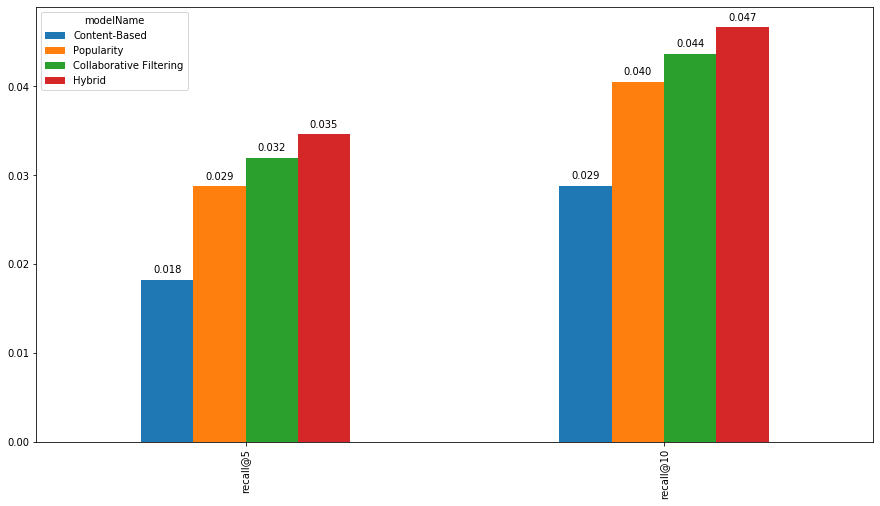

In [145]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [147]:
#Part 8: Testing the best model (hybrid) on the example user

hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

#These are very similar to the ones recommended in the tutorial with variation in rank

,recStrengthHybrid,contentId,title,url,lang
0,29.960542,3269302169678465882,The barbell effect of machine learning.,http://techcrunch.com/2016/06/02/the-barbell-e...,en
1,29.727934,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
2,29.577425,5092635400707338872,Power to the People: How One Unknown Group of ...,https://medium.com/@atduskgreg/power-to-the-pe...,en
3,29.152826,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
4,29.118171,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
5,28.896248,2468005329717107277,How Netflix does A/B Testing - uxdesign.cc - U...,https://uxdesign.cc/how-netflix-does-a-b-testi...,en
6,28.852274,-5756697018315640725,Being A Developer After 40 - Free Code Camp,https://medium.freecodecamp.com/being-a-develo...,en
7,28.850470,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
8,28.826287,4241385837165861843,Understanding the Twitter topic Tracker,https://unionmetrics.zendesk.com/hc/en-us/arti...,en
9,28.816898,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
